In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import astropy_mpl_style
from tqdm import tqdm
import os

plt.style.use(astropy_mpl_style)

Code to extract coordinates from the config file

In [6]:
def read_coordinates_from_file(file_path):
    coordinates = []

    with open(file_path, 'r') as file:
        # Skip the first 3 lines starting with #
        lines = file.readlines()[3:]

        for line in lines:
            # Check if the line starts with #
            if line.startswith('#'):
                continue  # Skip the line if it starts with #
            
            # Split each line by space to separate the coordinates
            parts = line.strip().split()

            # Check if the line contains enough data (at least x, y, z)
            if len(parts) >= 3:
                # Extract x, y, z coordinates and convert them to floats
                x = float(parts[0])
                y = float(parts[1])
                z = float(parts[2])

                # Append the coordinates to the list
                coordinates.append((x, y, z))

    return coordinates




In [7]:
# Example usage:
file_path = "alma.cycle5.8.cfg"  # Replace with your file path
coordinates = read_coordinates_from_file(file_path)

# Print the coordinates
for i, (x, y, z) in enumerate(coordinates, start=1):
    print(f"Coordinates {i}: x={x}, y={y}, z={z}")

Coordinates 1: x=-93.14292454, y=-745.9594809, z=-1.941492838
Coordinates 2: x=103.7166566, y=-847.9917404, z=-4.492461166
Coordinates 3: x=210.9519612, y=-760.3395825, z=-7.722003145
Coordinates 4: x=-201.6202627, y=-507.5851383, z=2.951531452
Coordinates 5: x=210.9983374, y=-883.4663621, z=-6.966940771
Coordinates 6: x=-115.7063626, y=-1075.443396, z=6.891886507
Coordinates 7: x=278.4170757, y=-571.5711321, z=-11.94579167
Coordinates 8: x=-370.9743358, y=-604.1237343, z=-0.592510746
Coordinates 9: x=159.5060551, y=-1067.094353, z=-1.914648891
Coordinates 10: x=28.89945077, y=-305.4170846, z=-2.93440994
Coordinates 11: x=-322.5251719, y=-1004.125527, z=-3.523531944
Coordinates 12: x=-405.2355233, y=-342.1436331, z=-1.631073652
Coordinates 13: x=-235.4166998, y=-182.5357693, z=0.433037607
Coordinates 14: x=-588.9825375, y=-511.8803954, z=-3.700789767
Coordinates 15: x=442.0178226, y=-1210.840727, z=-7.453735492
Coordinates 16: x=664.4987582, y=-652.3727712, z=-21.8190797
Coordinates 17

We are going to write a python script that calculates the Euclidean distance between the Antenna. This will help us find the maximum baseline length in Units if _ _ _ _ 

In [8]:
import math

def distance(point1, point2):
    """
    Calculate the Euclidean distance between two points in 3D space.
    
    Arguments:
    point1 (tuple): (x, y, z) coordinates of the first point.
    point2 (tuple): (x, y, z) coordinates of the second point.
    
    Returns:
    float: The Euclidean distance between the two points.
    """
    x1, y1, z1 = point1
    x2, y2, z2 = point2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

def farthest_points(points):
    """
    Find the pair of points with the farthest distance apart.
    
    Arguments:
    points (list of tuples): List of points, where each point is represented as a tuple (x, y, z).
    
    Returns:
    tuple: A tuple containing the two points with the farthest distance apart.
    """
    max_distance = 0
    farthest_pair = None
    for i, point1 in enumerate(points):
        for j, point2 in enumerate(points):
            if i != j:
                d = distance(point1, point2)
                if d > max_distance:
                    max_distance = d
                    farthest_pair = (point1, point2)
    return farthest_pair




In [9]:

farthest_pair = farthest_points(coordinates)
max_baseline = distance(farthest_pair[0], farthest_pair[1])
print("Points with the farthest distance apart:", farthest_pair)
print("Distance between them:", max_baseline)

Points with the farthest distance apart: ((-2807.877, 1412.598, -66.202), (4763.027, -2555.54, -59.388))
Distance between them: 8547.79228776975


Useful Definitions & Calculation of Field Of View

In [10]:
S_distance  = 140. # stands for distance to object in Simulation in pc from the #Map section of test.para used for the simulation
D_FOV = 1.5873E-3 # gives me the total FOV of the images in degrees, Gotten from the headers of the fits files

# the field of view in pc from the source is 
M_FOV = 2 * S_distance * math.tan(math.radians(D_FOV) / 2)
pad         = 4      # factor by which we will pad so we don't have aliasing when taking fft
distance    = 140. # distance to the source in units of pc
x           = 600    # number of pixels in each direction in the images
uvpix       = (distance/(M_FOV*pad))*10**-9# size of each pixel in Glambda when we take the fft



In [11]:
print(M_FOV)

0.003878505570614899


In [12]:
print(uvpix)

9.024094296827603e-06


In [13]:
# to find the radius in GLambda, we need to use the following equation

radius = max_baseline / (0.87 * 10**-3 * 10**9) # the observation were made in the 0.87mm wavelength and the 10^9 is to convert to GLambda

I DON'T KNOW WHAT UNIT max_baseline IS

In [14]:
print(radius * uvpix)

8.866216509716088e-08


In [15]:
even_numbers = [f'{num:05}' for num in range(0, 251, 10)] # I did this cause the valid snapshots which produced images were all even numbered i.e they were of the format snapshot101_X where X is the 5 digit format of even numbers
valid_image_data = []

for i in tqdm(even_numbers, desc="Getting Array ready"):
    fits_image_filename = f"../simulated_observation/job_{i}/data_1300/RT.fits.gz"
    if os.path.exists(fits_image_filename):

        try:
            image_data = fits.getdata(fits_image_filename, ext=0)
            valid_image_data.append([i,image_data]) #the reason why I did this (append both i and the image data) is to be able to retrace where particular image data came from. Turns out that it wasn't very useful here
        # Continue processing with the data if no error occurred
        except Exception as e:
            print(f"Error reading FITS file {fits_image_filename}: {e}")
        # Handle the error as needed
        continue  # Continue to the next iteration
        
        
    else:
        print(f"The directory {fits_image_filename} does not exist.")

Getting Array ready:   0%|          | 0/26 [00:00<?, ?it/s]

Getting Array ready: 100%|██████████| 26/26 [00:08<00:00,  2.94it/s]


In [16]:
ppd_image = [array[1] for array in valid_image_data] #image data extraction
suitable_format = []
for image in ppd_image:
    suitable_format.append(image[0, 0, 0, :, :])

image_cube = np.stack(suitable_format, axis=0)
image_cube.shape
    


(26, 600, 600)

In [17]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt       
from matplotlib import rcParams       # import to change plot parameters
from matplotlib import cm             # imports colormaps
from matplotlib.ticker import MultipleLocator, FormatStrFormatter 
# we will use the line above to make the big plot of the PCA components below

import numpy as np                    # imports library for arrays

# Below I import my own library. On my laptop they are located in home+'/Dropbox/research/master_code'
# Change that line of code so that it matches the location of the files on your laptop
import sys
from os.path import expanduser
home = expanduser("~")
sys.path.append(home+'/Documents/UGA_Research/forJuvis')
from my_func import * # my module with some helpful functions
from my_plot import * # my module with some plotting functions
from my_pca  import * # my module with some PCA functions

textwidth   = 7.1014
columnwidth = 3.39441
font        = 12

In [43]:
def padding2D(array, x0=0, y0=0, pad=8, type_complex=False):
    """!@brief Pads a 2D array by a factor pad.
    
    Makes a new array where each axis is pad times original size, 
    and then puts the original array in the center of this new big one. 
    The result will be the original array padded by many zeros on all sides.
    This function is used by myfft() and myfft_centered().
    
    @param array 2D numpy array.
     
    @param x0 optional keyword, default set to zero, if not set to zero 
    will offset the original array such that it is centered x0 away from 
    the center of the big array.
    
    @param y0 optional keyword, default set to zero, if not set to zero 
    will offset the original array such that it is centered y0 away from 
    the center of the big array.
    
    
    @param pad optional keyword, default set to 8. This is the factor by which 
    to pad the array before taking the fft.
    
    @param type_complex optional keyword, default set to False. If True, will 
    assume the input array is complex and return a complex array.
    
    @returns a 2D numpy array of floats, new array is pad times bigger 
    than original, and has original centered x0,y,0 away from the center.
    """
    ss = np.shape(array)
    if len(ss)==2:
        s = ss[0]
        padded = np.zeros((s*pad, s*pad))
        if type_complex==True: padded = np.array(padded,dtype=complex)
        padded[int(s*(pad-1)/2-y0): int(s*(pad+1)/2-y0), int(s*(pad-1)/2-x0): int(s*(pad+1)/2-x0)] = array
    elif len(ss)==3:
        s = ss[1]
        padded = np.zeros(((ss[0], s*pad, s*pad)))
        if type_complex==True: padded = np.array(padded,dtype=complex)
        padded[:, int(s*(pad-1)/2-y0): int(s*(pad+1)/2-y0), int(s*(pad-1)/2-x0): int(s*(pad+1)/2-x0)] = array
    return(padded)

def butterworth_filt(x,y,radius,n):
    """!@brief calculates kernel for Butterworth filter.
    
    Calculates the following equation
    
    \f[
    K = \frac{1}{\sqrt{1+(\sqrt{x^2+y^2}/R)^{2n}}}.
    \f]  
    for a given location in the image, this is used when making the mask for the Butterworth filter.
    See for example https://en.wikipedia.org/wiki/Butterworth_filter.
    
    @param x location in the x direction in the image.
    
    @param y location in the y direction in the image.
    
    @param radius radius of the Butterworth filter in units of pixels.
    
    @param n parameter for the Butterworth filter.
       
    @returns the result of the above equation.
    """
    return(1./(np.sqrt(1.+((np.sqrt(x*x+y*y)/radius)**(2.*n)))))

def mask_butterworth_filt(radius = 100, n=2,y=512):
    """!@brief creates the mask for the Butterworth filter.
    
    Calls butterworth_filt() for each location in a 2D array. 
    
    * Note that if you are planning to pad your images when you perform the convolution using 
    filter_image_padded() then you need to pad the mask as well so x should be x*pad where x 
    in this case is the size of your original images.
    
    @param radius opitional keyword, default set to 100, radius of the Butterworth filter in units of pixels.
    
    @param n optional keyword, default set to 2, parameter for the Butterworth filter.
    
    @param x number of pixels in each direction you want in the resulting 2D array.
       
    @returns the 2D numpy array containing the mask for the Butterworth filter.
    """
    x = int(y)
    mask_filt = np.zeros((x,x))
    for i in range(0,x):
        for j in range(0,x):
            ii = i-x/2
            jj = j-x/2
            mask_filt[i,j]=butterworth_filt(ii,jj,radius,n)
    return(mask_filt)

def filter_image_padded(image, mask, pad=4):
    """!@brief applies given mask to a given image. 

    Performs a convolution, multiplies the mask by the Fourier transform of the given image.

    @param image 2D numpy array containing the image you want to filter. 

    @param mask should be the result of the mask_butterworth_filt() function but should 
    have a size equal to the size of image multiplied by pad.

    @param pad optional keyword, default set to 4, this is the factor by which we pad so we 
    don't have aliasing when taking the Fourier transform

    @returns the 2D numpy array containing the mask for the Butterworth filter.
    """
    image = padding2D(image, pad=pad)
    mask  = padding2D(mask,  pad=pad)
    FT    = myfft(image,-1,pad=False)*mask
    image_filt = myifft(np.abs(FT),np.angle(FT),-1,pad=False)
    image_filt = unpad2D(np.abs(image_filt), pad=pad)
    return(image_filt)


In [44]:
mask_butter = mask_butterworth_filt(radius=65, n=2,y=x) 

In [45]:
image = image_cube[0,:,:]
print(image.shape)

(600, 600)


In [46]:
print(mask_butter.shape)

(600, 600)


In [47]:

image_filt1 = filter_image_padded(image, mask_butter, pad=pad)

In [48]:
print(image_filt1.shape)

(600, 600)


In [52]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot_log_image(image, title=None, logScale=False):
  """
  Plots an image with logarithmic color scale using Astropy and Matplotlib.

  Args:
    image: The 2D image data as a NumPy array.
    title: The title to display for the plot (optional).
  """

  # Create the plot figure
  plt.figure()

  # Use imshow with LogNorm for logarithmic color scale
  if logScale:
    plt.imshow(image, norm=LogNorm())
  else:
    plt.imshow(image)


  # Add title if provided
  if title:
    plt.title(title)

  # Set colorbar and label
  plt.colorbar(label='Pixel Value (Log Scale)')

  # Show the plot
  plt.show()


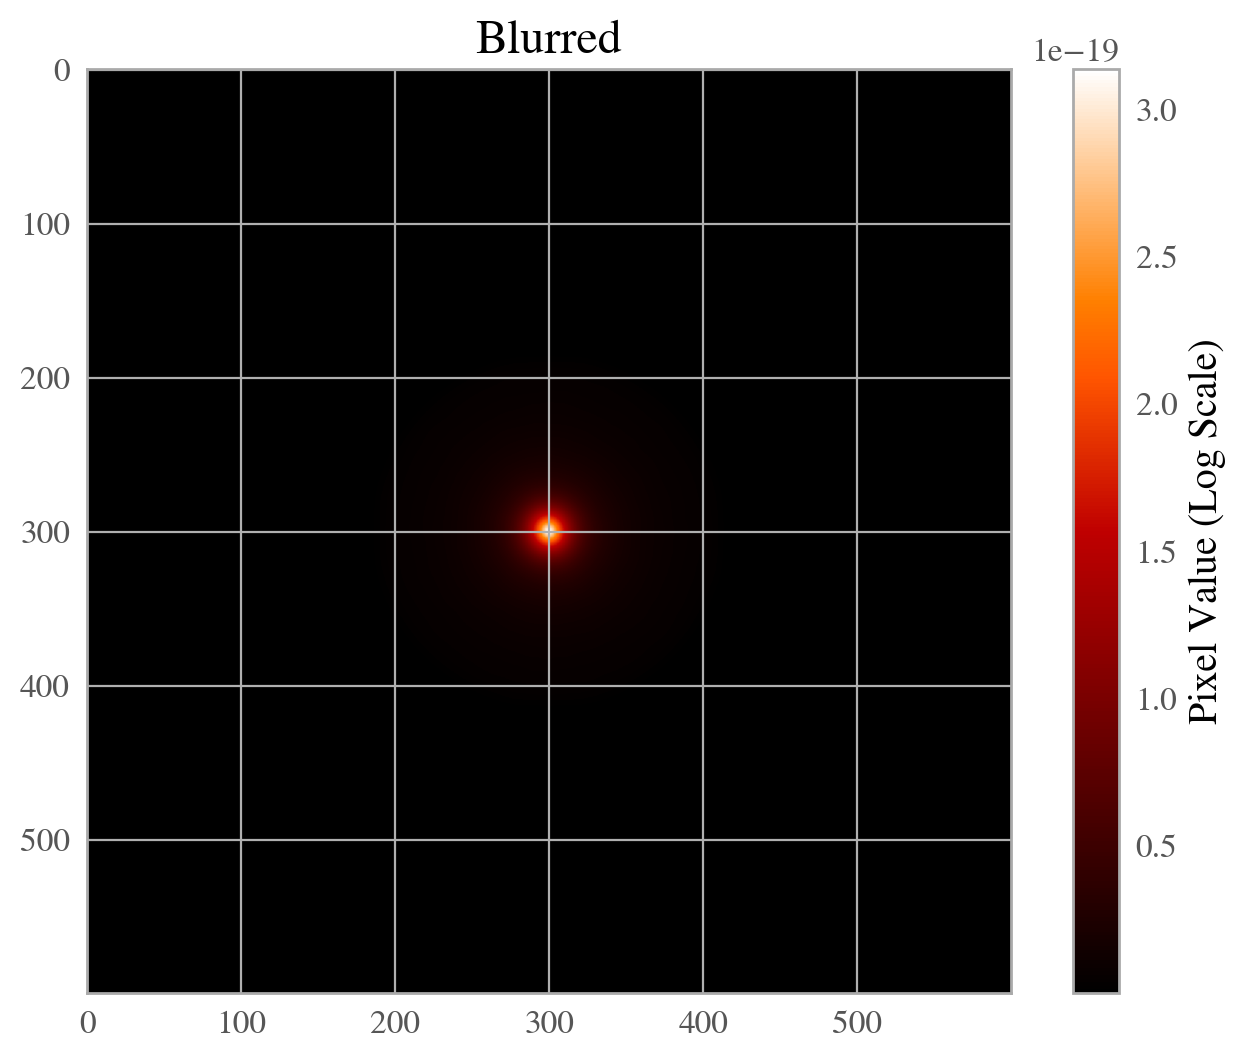

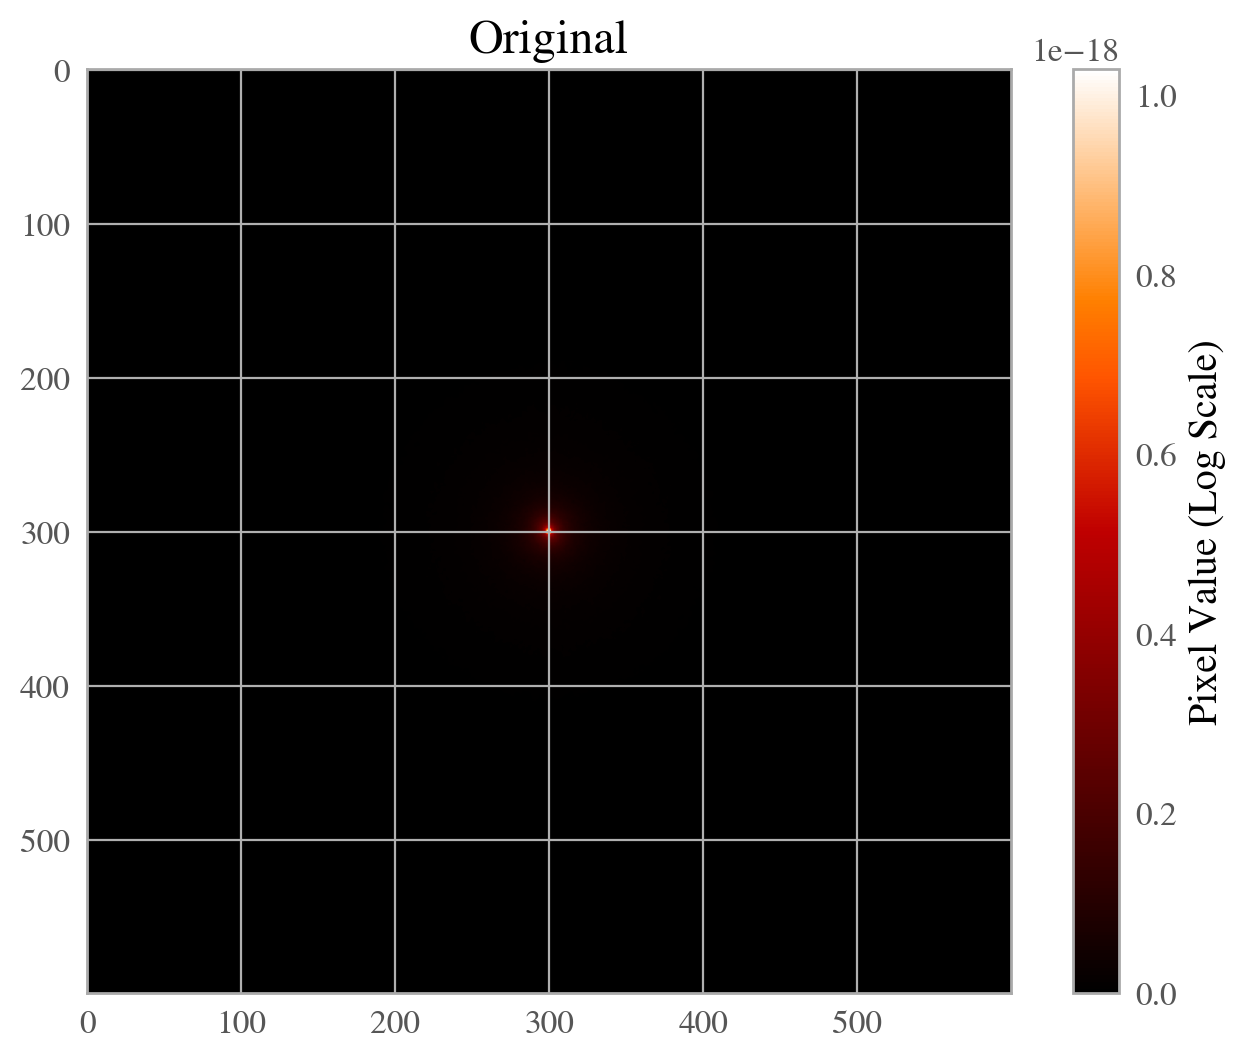

In [53]:

plot_log_image(image_filt1,title='Blurred') # plotting the blurred image
plot_log_image(image,title='Original') # plotting the original image

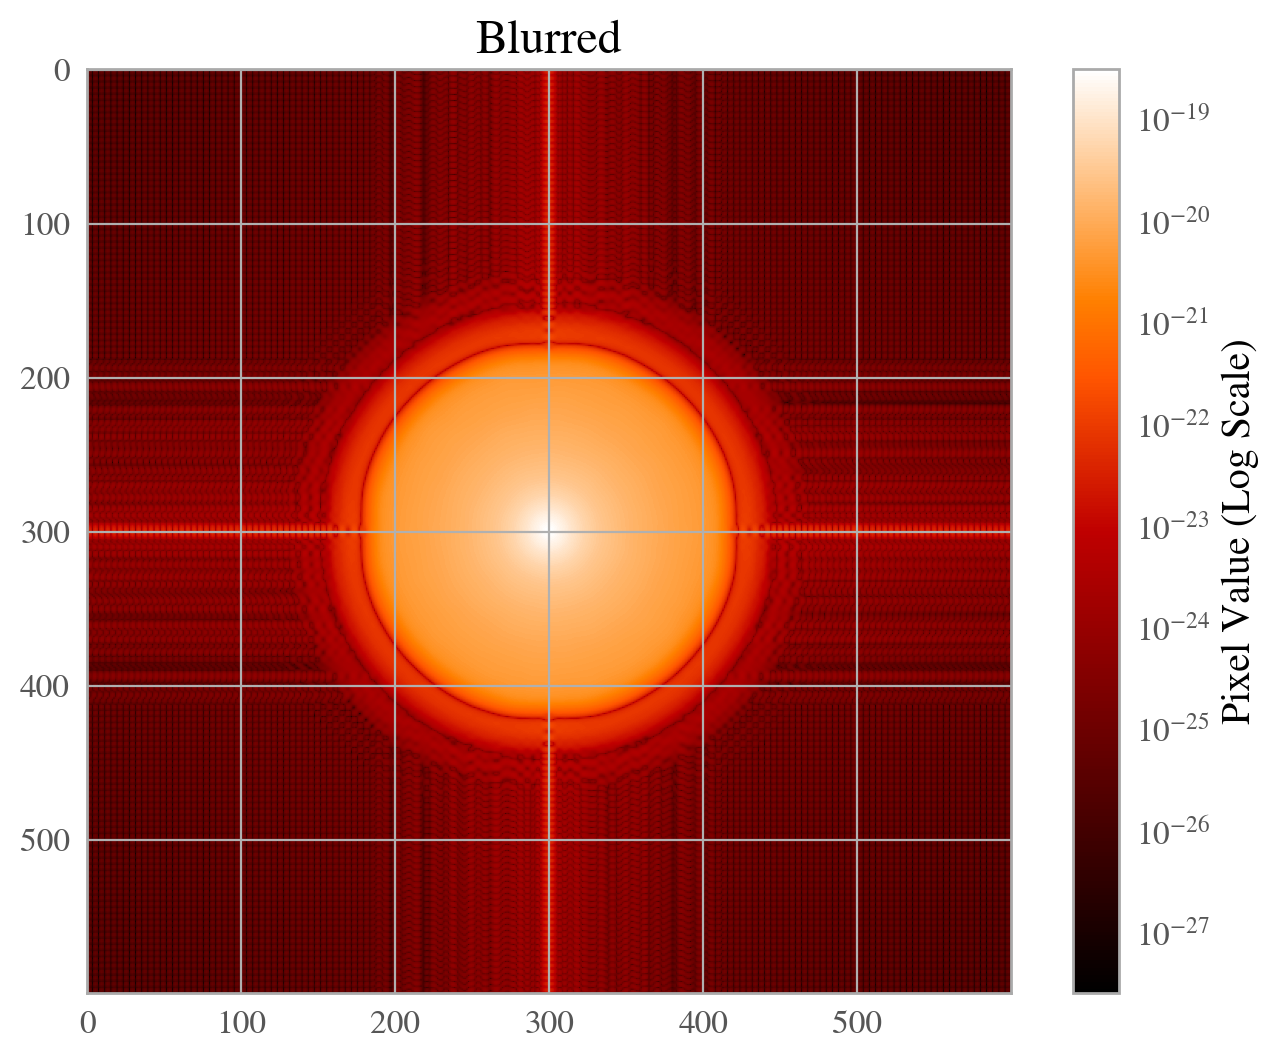

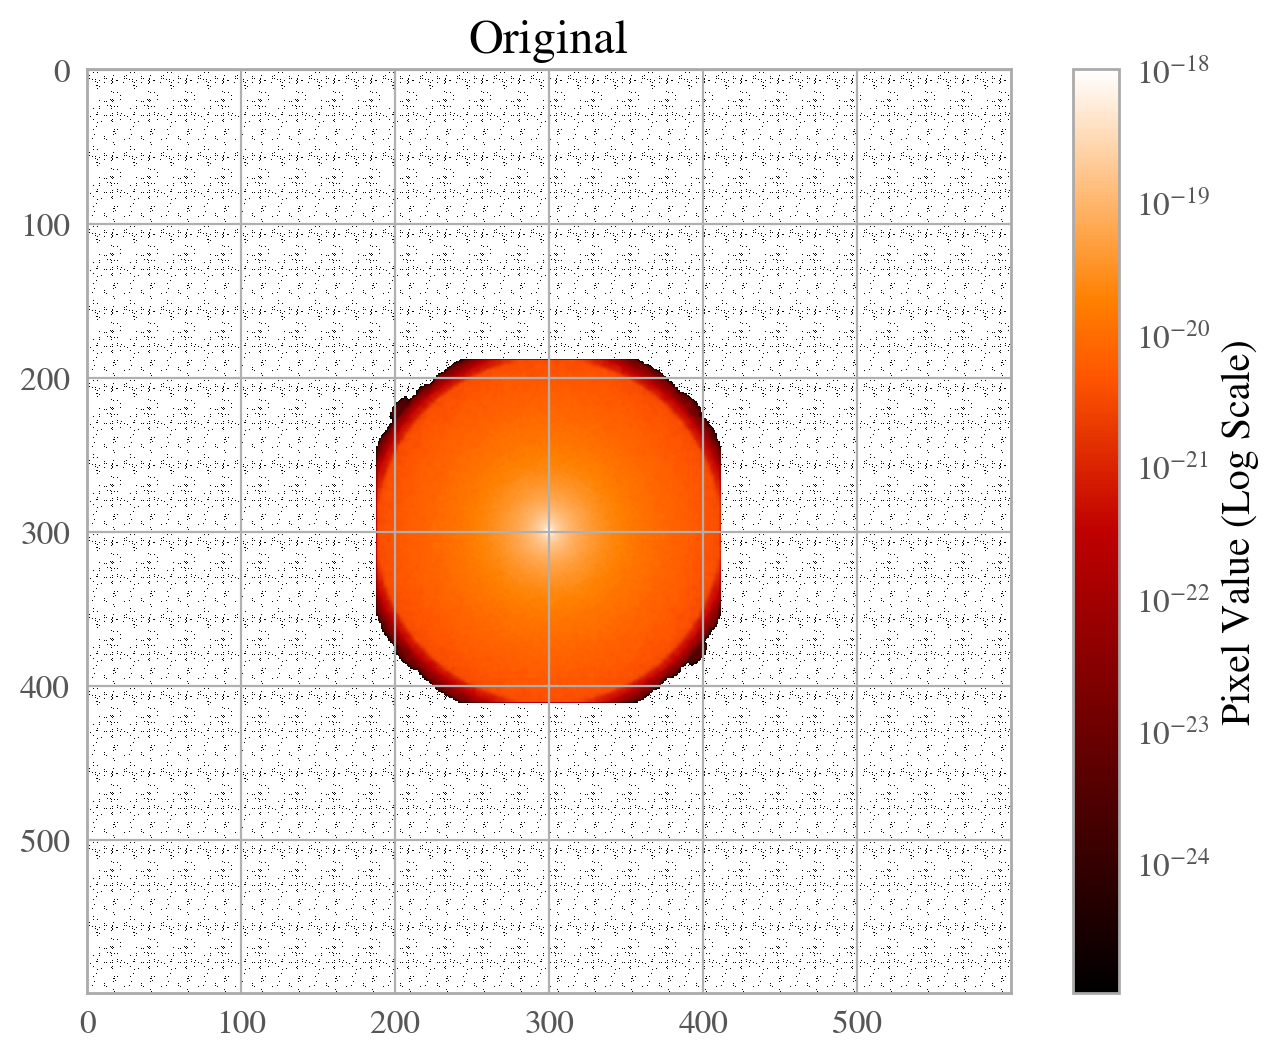

In [54]:
#plotting log scales

plot_log_image(image_filt1,title='Blurred', logScale=True) # plotting the blurred image
plot_log_image(image,title='Original',  logScale=True) # plotting the original image